In [2]:
using Optim
using LinearAlgebra
using SparseArrays
using CairoMakie
using Piccolo

# let's define a shorthand for kron
const ⊗ = kron

kron (generic function with 42 methods)

# Getting started
-----

## Review
- Gradient descent
- Newton's method and KKT conditions
- Regularization
- Newton approximations
- Line search

## Goals
- Introduce trajectory optimization
- Solve the LQR problem three ways
- Describe nonlinear trajectory optimization

# I. Trajectory optimization
-----

- The solution is a definite _trajectory_, not a feedback policy.

\begin{align}
\min_{x_{1:N}, u_{1:N-1}} &\quad J(x_{1:N}, u_{1:N-1}) = \sum_{n=1}^N \ell_n(x_n, u_n) + \ell_N(x_N, u_N) \\
\text{s.t.} &\quad x_{n+1} = f(x_n, u_n, n)
\end{align}

## Named Trajectories

**Terminology**

- _Snapshot matrix_, $Z = \begin{bmatrix} | & | & & | \\ z_1 & z_2 & & z_T \\ | & | & & | \end{bmatrix}$
- _Knot point_, $z_1 = \begin{bmatrix} x_1 \\ u_1 \end{bmatrix}$

In [3]:
N = 10 # Number of knot points
traj = rand(NamedTrajectory, N)

T = 10, (x = 1:3, u = 4:5, → Δt = 6:6)

In [4]:
traj.x

3×10 view(reshape(view(::Vector{Float64}, :), 6, 10), 1:3, :) with eltype Float64:
  0.129017   1.06202    0.462403  …  0.79552    0.0450414  -0.483722
  0.43614    0.731537   0.653701     0.336882   2.41602     1.6288
 -0.50286   -0.462956  -0.583373     0.574069  -0.245517   -0.967703

In [5]:
traj.u

2×10 view(reshape(view(::Vector{Float64}, :), 6, 10), 4:5, :) with eltype Float64:
  1.34215   0.935859   0.433945  …   0.639595  0.154639  -0.0716939
 -0.815194  0.553892  -0.412727     -1.10177   0.350547  -0.526455

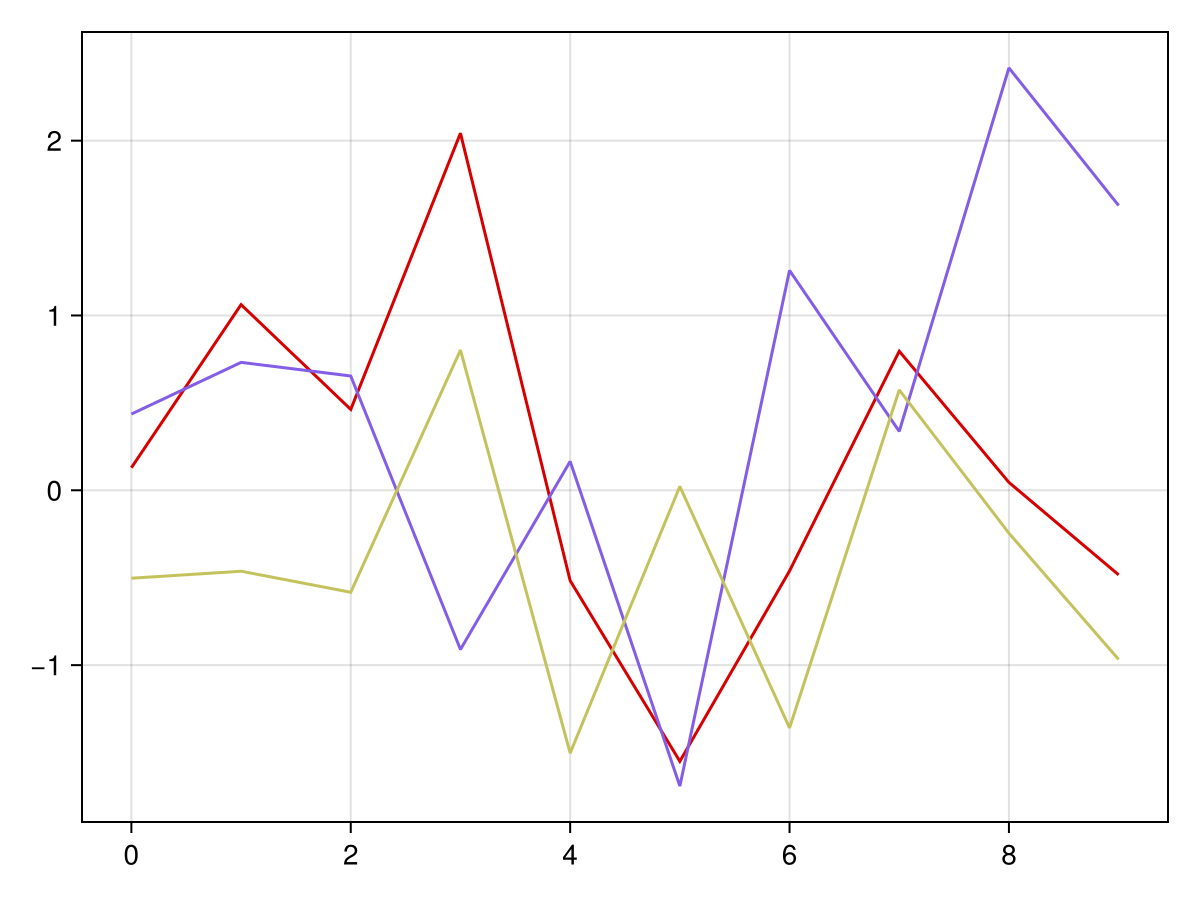

In [6]:
plot(traj, :x)

# II. Linear Quadratic Regulator
-----

- LQR is the "simple Harmonic oscillator" of control

\begin{align}
\min_{x_{1:N}, u_{1:N{-}1}} &\quad J = \sum_{n=1}^{N-1} \tfrac{1}{2} x_n^T Q_n x_n + \tfrac{1}{2} u_n^T R_n u_n + \tfrac{1}{2} x_N^T Q_N x_N \\
\text{s.t.} &\quad x_{n+1} = A_n x_n + B_n u_n \\
&\quad Q_n \succeq 0,\, R_n \succ 0
\end{align}

- Quick check: Why does $R$ need to be positive definite?

## Linear systems

### Zero-order hold

- Zero-order hold can be used to convert continuous, linear, time-invariant (LTI) systems to discrete LTI systems.

\begin{align}
\dot{x}(t) &= A x(t) + B u(t)  \\
\overset{h}{\longrightarrow} x(t+h) &= A_h x(t) + B_h u(t) \\
&= \left( \sum_{n\ge0} \tfrac{1}{n!} A^n h^n \right) x + \left( \sum_{n\ge1} \tfrac{1}{n!} A^{n-1} B h^n \right) u \\
&\approx (I + h A) x + h B u
\end{align}

- Matrix exponential trick:

\begin{equation}

\exp\left(\begin{bmatrix} A & B \\ 0 & 0 \end{bmatrix} h \right)
= \begin{bmatrix} A_h & B_h \\ 0 & I \end{bmatrix}

\end{equation}

In [7]:
# Define continuous LTI system matrices
A = [0.0 1.0; -1.0 -0.1]
B = [0.0; 1.0]
h = 0.1  # Time step

function continuous_to_discrete(A, B, h)
    # Construct augmented matrix for matrix exponential
    augmented_matrix = [
        A B; 
        zeros(size(B, 2), size(A, 1)) zeros(size(B, 2), size(B, 2))
    ]

    # Compute matrix exponential
    exp_matrix = exp(augmented_matrix * h)

    # Extract discrete LTI system matrices
    A_h = exp_matrix[1:size(A, 1), 1:size(A, 2)]
    B_h = exp_matrix[1:size(A, 1), size(A, 2)+1:end]

    return A_h, B_h
end

# Extract discrete LTI system matrices
A_h, B_h = continuous_to_discrete(A, B, h);

In [8]:
A_h

2×2 Matrix{Float64}:
  0.995021   0.0993359
 -0.0993359  0.985087

In [9]:
I + A * h

2×2 Matrix{Float64}:
  1.0  0.1
 -0.1  0.99

In [10]:
B_h

2×1 Matrix{Float64}:
 0.004979226257922404
 0.09933590957864684

In [11]:
B * h

2-element Vector{Float64}:
 0.0
 0.1

### Double Integrator

- Double integrator (Newton's second law, $F = ma$)

\begin{equation}

m \frac{d}{dt} \begin{bmatrix} q \\ \dot{q} \end{bmatrix} 
= \begin{bmatrix} 0 & m \\ 0 & 0 \end{bmatrix} \begin{bmatrix} q \\ \dot{q} \end{bmatrix}
+ \begin{bmatrix} 0 \\ u \end{bmatrix}

\end{equation}

In [12]:
function double_integrator(m)
    A_c = [0.0 1.0; 0.0 0.0]
    B_c = [0.0; 1.0 / m]
    return A_c, B_c
end

double_integrator (generic function with 1 method)

In [13]:
# simulate a discrete LTI system
function simulate_dlti(u::AbstractMatrix, A, B, x1)
    N = size(u, 2) + 1
    x = zeros(size(A, 2), N)
    x[:, 1] = x1
    for k in 1:N-1
        x[:, k + 1] = A * x[:, k] + B * u[:, k]
    end
    return x
end

function simulate_dlti(u::AbstractVector, A, B, x1)
    simulate_dlti(reshape(u, 1, length(u)), A, B, x1)
end

simulate_dlti (generic function with 2 methods)

In [14]:
m = 2.0 # Mass
A_c , B_c = double_integrator(m)
h = 0.05  # Time step
A, B = continuous_to_discrete(A_c, B_c, h);

In [15]:
A ≈ I + A_c * h

true

In [16]:
B ≈ B_c * h + [h^2 / 2m; 0]

true

## Indirect optimal control: Naive way

- Indirect optimal control is also known as "single shooting"

- The naive way is to perform gradient descent without any problem structure.

\begin{align}
\min_{u_{1:N{-}1}} &\quad J(u_{1:N{-}1}) = \sum_{n=1}^{N-1} \ell_n(x_n(u_{1:n{-}1}), u_n) + \ell_N(x_N(u_{1:N{-}1}), u_N) \\
\end{align}


- We will start with the double integrator and solve the LQR problem,
\begin{align}
\min_{u_{1:N{-}1}} &\quad J(u_{1:{N{-}1}}) = \sum_{n=1}^{N-1} \tfrac{1}{2} x_n(u_{1:n{-}1})^T Q_n x_n(u_{1:n{-}1}) + \tfrac{1}{2} u_n^T R_n u_n + \tfrac{1}{2} x_N(u_{1:N{-}1})^T Q_N x_N(u_{1:N{-}1}) \\
\text{s.t.} &\quad Q_n \succeq 0,\, R_n \succ 0
\end{align}

In [17]:
m = 0.1 # Mass
A_c, B_c = double_integrator(m)
h = 0.1  # Time step
A, B = continuous_to_discrete(A_c, B_c, h)
x1 = [1.0; 2.0]  # Initial state

Q = 1e-4I
R = 1e-1I
QN = 1e2I

UniformScaling{Float64}
100.0*I

In [18]:
function J(
    x::AbstractMatrix,
    u::AbstractVecOrMat;
    Q = 1e-2I, 
    R = 1e-4I, 
    QN = 1e2I
)
    u = isa(u, AbstractMatrix) ? u : reshape(u, 1, length(u))
    
    N = size(u, 2) + 1    
    J = 0.0
    for n in 1:N-1
        xₙ = x[:, n]
        uₙ = u[:, n]
        J += 1/2 * (xₙ' * Q * xₙ + uₙ' * R * uₙ)
    end
    J += 1/2 * (x[:, N]' * QN * x[:, N])
    return J
end

function J(u::AbstractVecOrMat; A=A, B=B, x1=x1, kwargs...)
    x = simulate_dlti(u, A, B, x1)
    return J(x, u; kwargs...)
end

J (generic function with 2 methods)

### Gradient descent

In [19]:
N = 40
u0 = randn(N - 1)
J(u0; A=A, B=B, x1=x1, Q=Q, R=R, QN=QN)

13186.77274665661

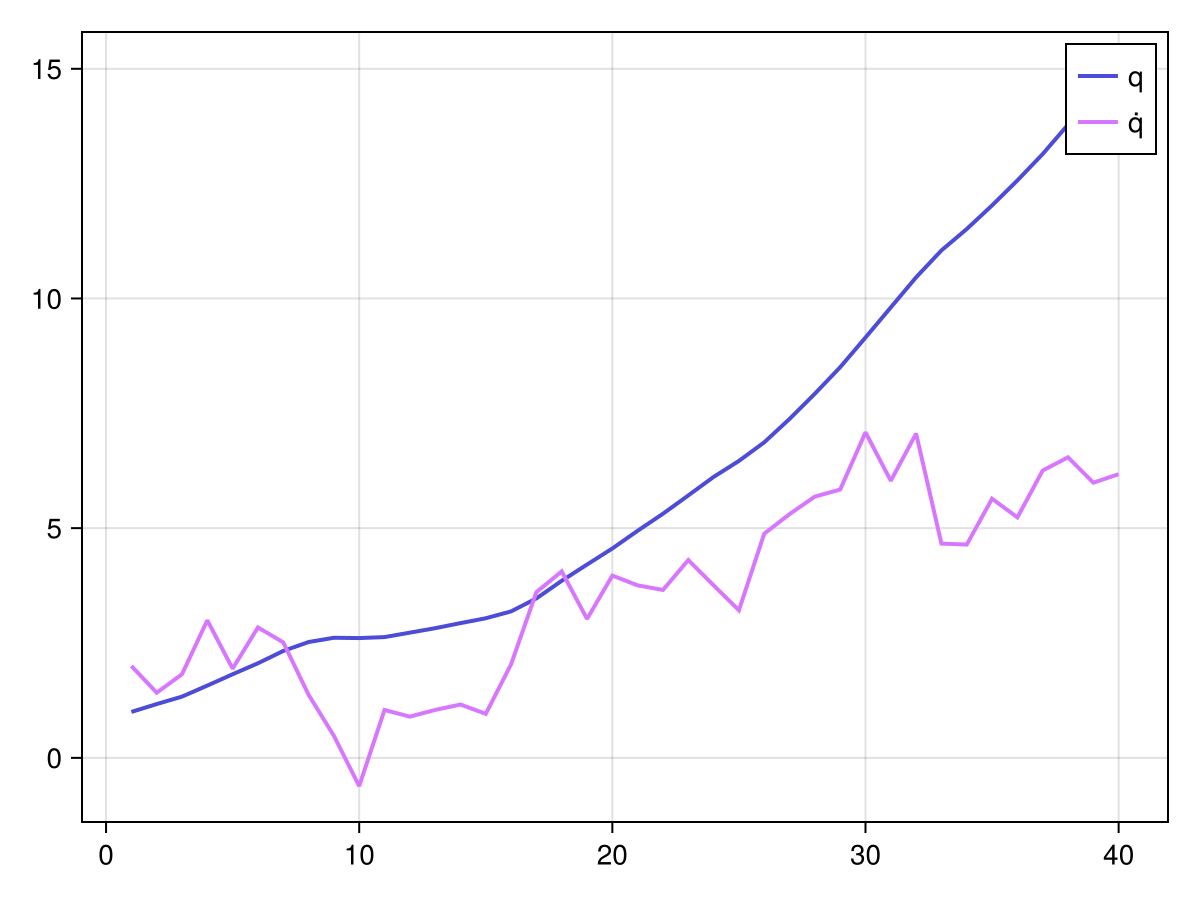

In [20]:
fig, ax = series(simulate_dlti(u0, A, B, x1), labels=["q", "q̇"])
axislegend(ax)
fig

In [21]:
res = optimize(u -> J(u; A=A, B=B, x1=x1, Q=Q, R=R, QN=QN), u0, GradientDescent())

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.552900e+00

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 8.91e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.66e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.88e-05 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.78e-05 ≰ 0.0e+00
    |g(x)|                 = 4.66e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    3002
    ∇f(x) calls:   3002


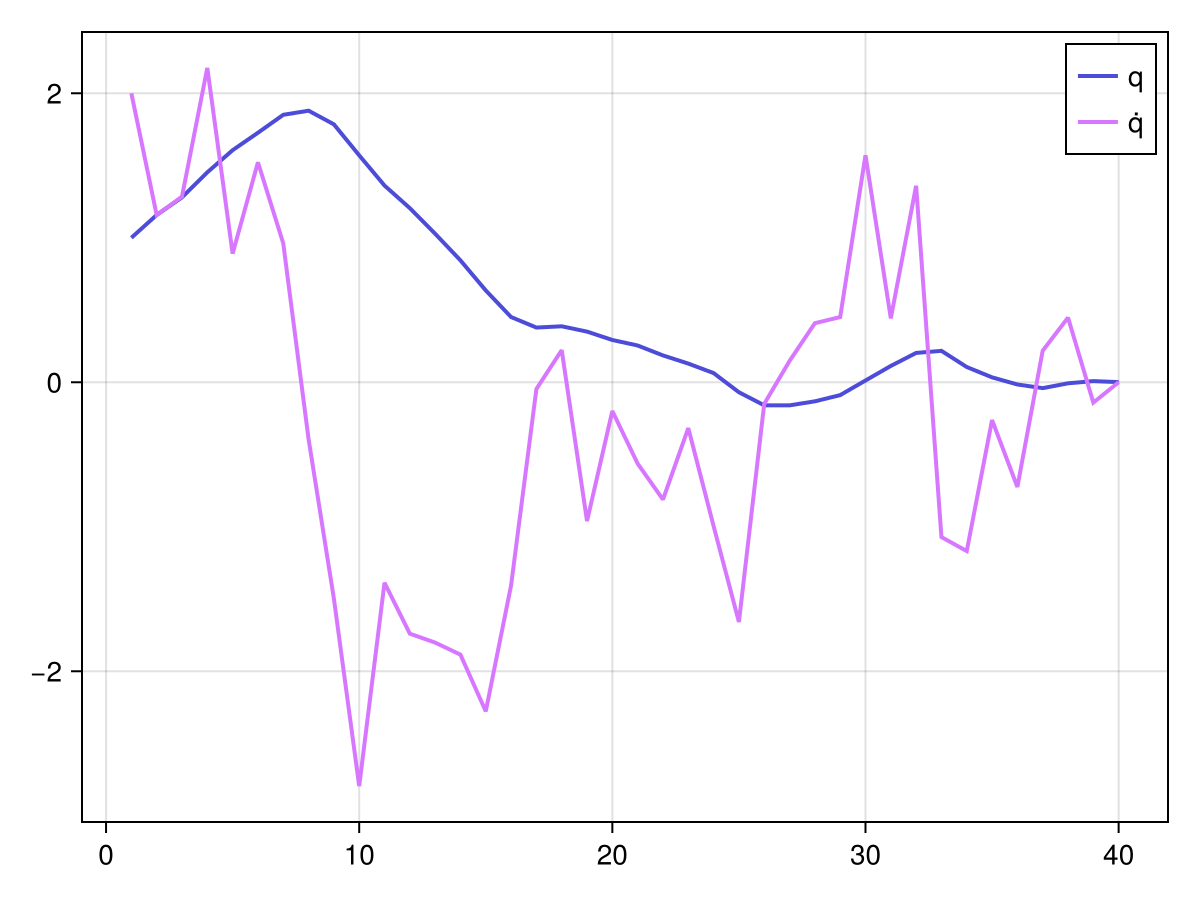

In [22]:
fig, ax = series(simulate_dlti(res.minimizer, A, B, x1), labels=["q", "q̇"])
axislegend(ax)
fig

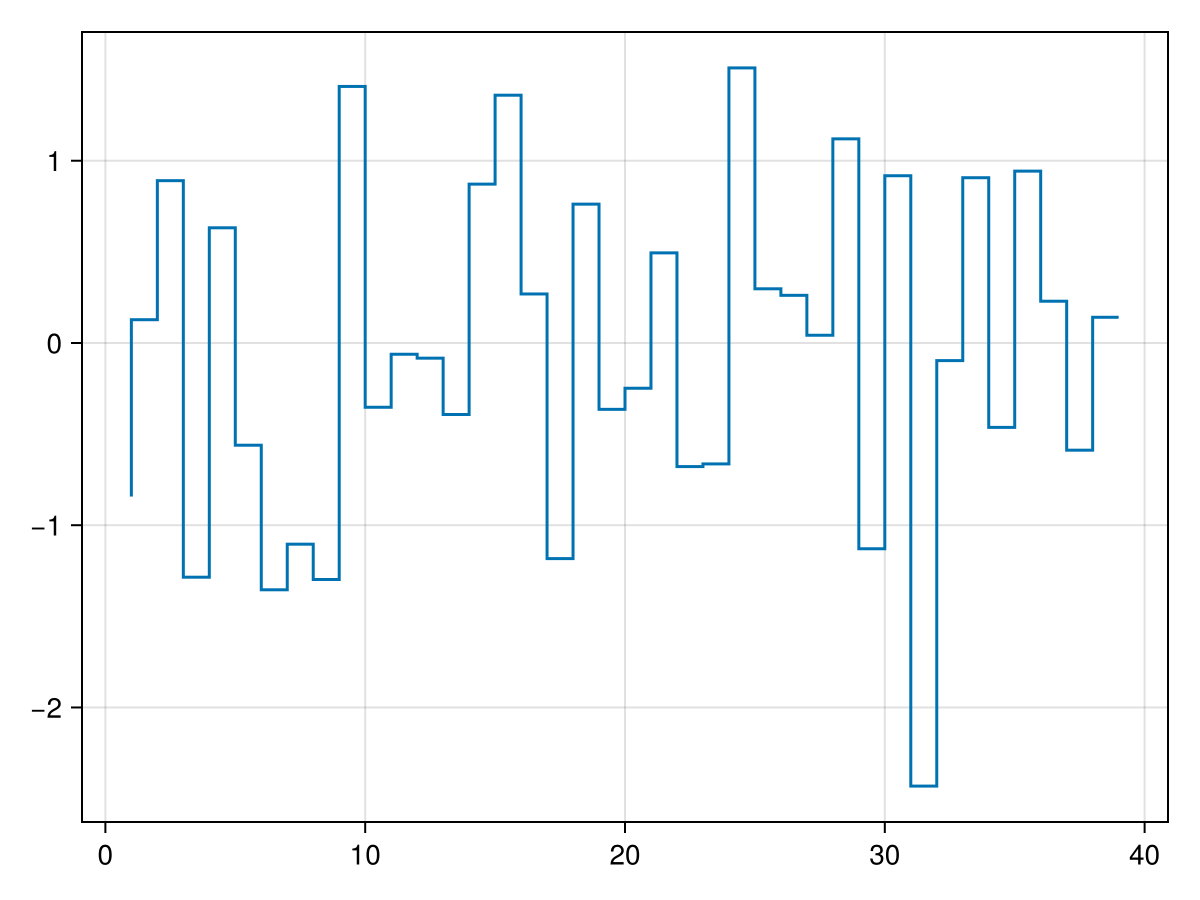

In [23]:
stairs(res.minimizer)

### Newton's method

In [24]:
# Newton must have vector input
res_newton = optimize(u -> J(u; A=A, B=B, x1=x1, Q=Q, R=R, QN=QN), u0, Newton())

 * Status: success

 * Candidate solution
    Final objective value:     3.418396e-02

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 1.53e-02 ≰ 0.0e+00
    |x - x'|/|x'|          = 5.75e-02 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.67e-05 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.66e-03 ≰ 0.0e+00
    |g(x)|                 = 1.83e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    2
    f(x) calls:    5
    ∇f(x) calls:   5
    ∇²f(x) calls:  2


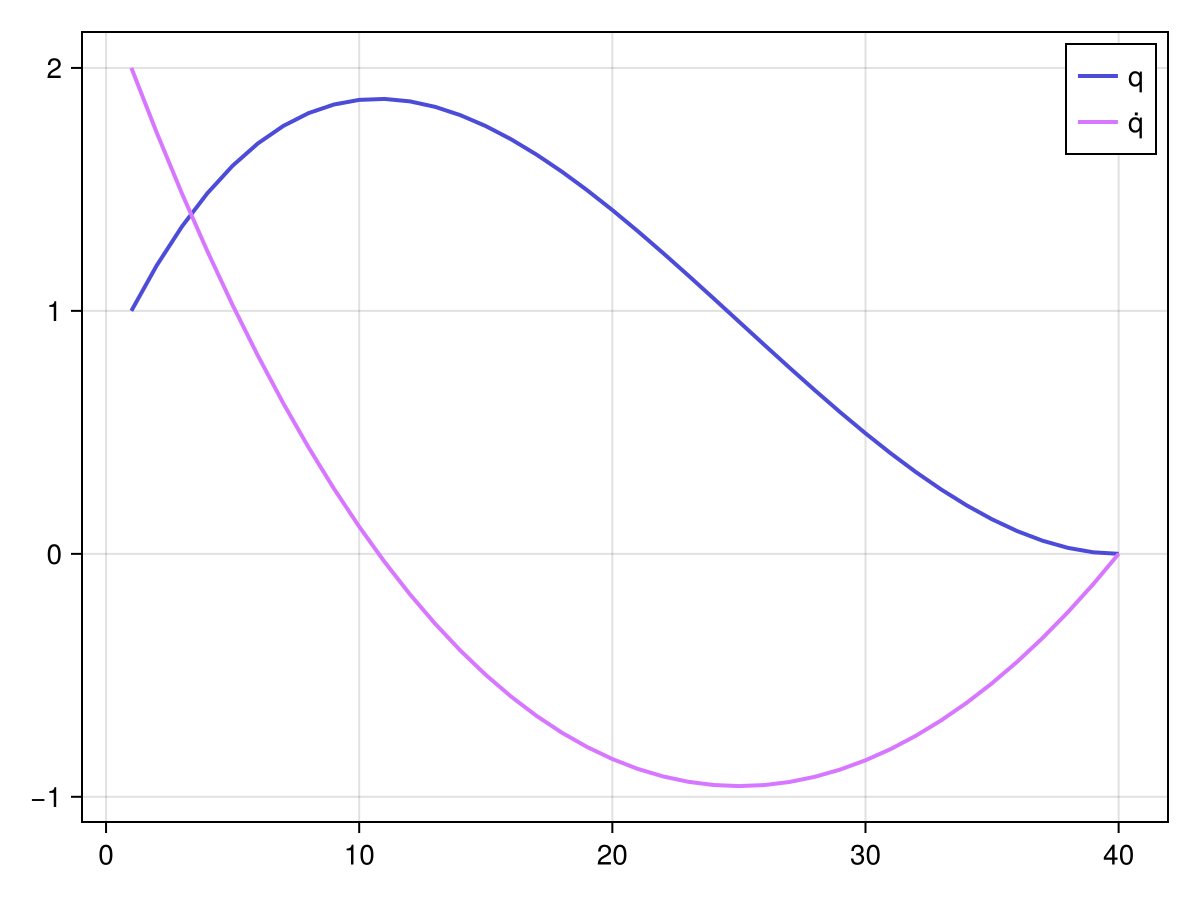

In [25]:
fig, ax = series(simulate_dlti(res_newton.minimizer, A, B, x1), labels=["q", "q̇"])
axislegend(ax)
fig

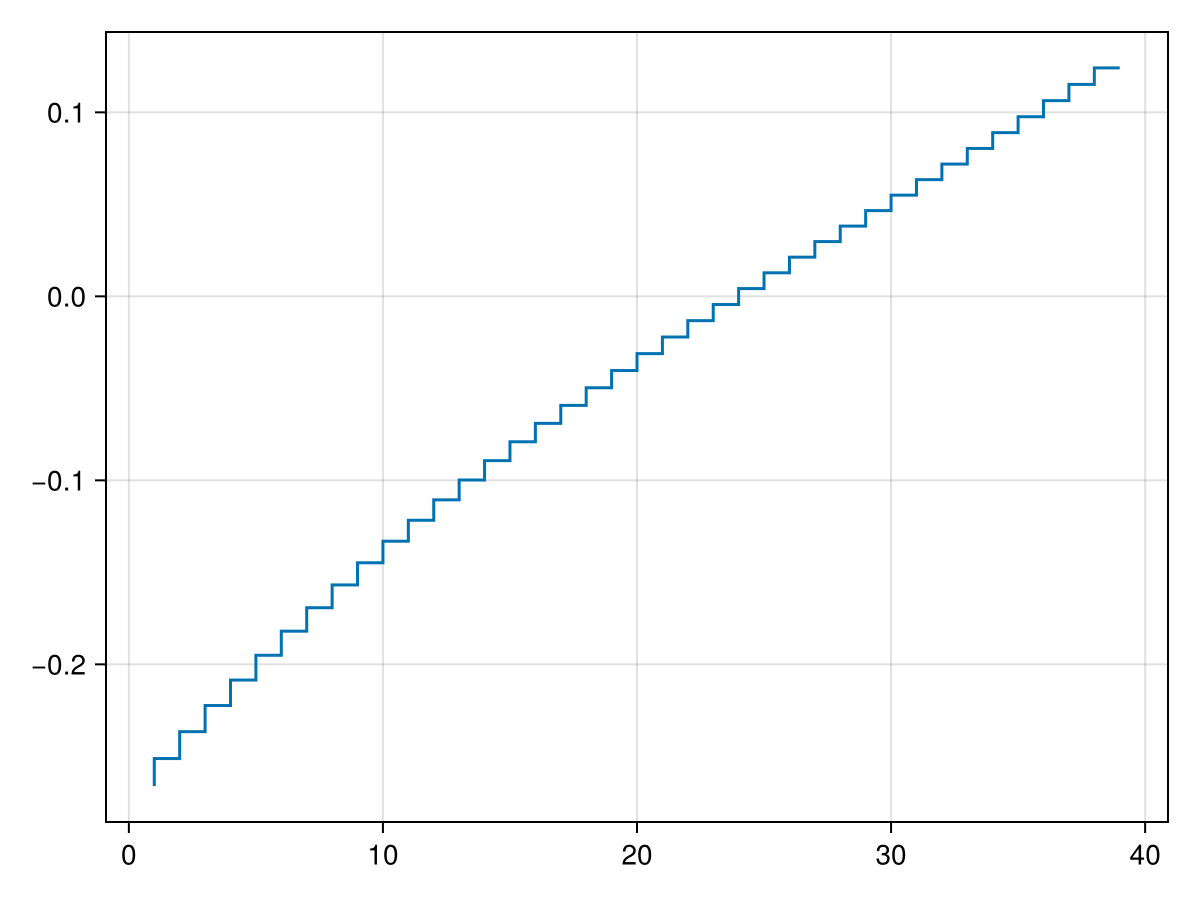

In [26]:
stairs(res_newton.minimizer)

## Indirect optimal control: Pontryagin

**Tagline**

"optimize, then discretize"

**Ideas**

- We can this in a smart way by using the temporal structure of the problem.

\begin{align}
\min_{x_{1:N}, u_{1:{N{-}1}}} & \quad J(x_{1:N}, u_{1:{N{-}1}}) = \sum_{n=1}^{N-1} \tfrac{1}{2} x_n^T Q_n x_n + \tfrac{1}{2} u_n^T R_n u_n + \tfrac{1}{2} x_N^T Q_N x_N \\
\text{s.t.} &\quad x_{n+1} = A_n x_n + B_n u_n \\
&\quad Q_n \succeq 0,\, R_n \succ 0
\end{align}



- Lagrangian:

\begin{equation}
    L(x_{1:N}, u_{1:{N{-}1}}, \lambda_{2:N}) = \sum_{n=1}^{N-1} \tfrac{1}{2} x_n^T Q_n x_n + \tfrac{1}{2} u_n^T R_n u_n + \lambda_{n+1}^T(A_n x_n + B_n u_n - x_{n+1}) + \tfrac{1}{2} x_N^T Q_N x_N 
\end{equation}

- KKT conditions:

\begin{align}
    \frac{\partial L}{\partial \lambda_n} &= (A_n x_n + B_n u_n - x_{n+1})^T \overset{!}{=} 0 \\
    \frac{\partial L}{\partial x_n} &= x_n^T Q_n + \lambda_{n+1}^T A_n - \lambda_{n}^T \overset{!}{=} 0 \\
    \frac{\partial L}{\partial x_N} &= x_N^T Q_N - \lambda_{N}^T \overset{!}{=} 0 \\
    \frac{\partial L}{\partial u_n} &= u_n^T R_n + \lambda_{n+1}^T B_n \overset{!}{=} 0
\end{align}

- Rewrite:

\begin{align}
    x_{n+1} &= A_n x_n + B_n u_n \\
    \lambda_{n} &= A_n^T \lambda_{n+1} + Q_n x_n \\
    \lambda_N &= Q_N x_N \\
    u_n &= -R_n^{-1} B_n^T \lambda_{n+1}
\end{align}

- There is a _forward_ equation and a _backward_ equation. This computation is _backpropagation_ through time.
- We inherit many of the  same problems, e.g., vanishing / exploding gradients.

In [27]:
N = 100
m = 1.0 # Mass
A_c, B_c = double_integrator(m)
h = 0.1  # Time step
A, B = continuous_to_discrete(A_c, B_c, h)
x1 = [1.0; 1.0]  # Initial state

Q = 1e-4I
R = 1e-2I
QN = 1e1I

UniformScaling{Float64}
10.0*I

In [28]:
# Initial guess
u = zeros(1, N - 1)
Δu = ones(1, N - 1)
x = simulate_dlti(u, A, B, x1)
λ = zeros(size(x, 1), N)

# Line search
α = 1.0 # Step size
b = 1e-2 # Tolerance
α_min = 1e-16 # Minimum step size
loop = 0

# Verbose
verbose = false

while maximum(abs, Δu) > 1e-2 && α > α_min
    verbose ? println("Iteration: ", loop) : nothing

    # Backward pass to compute λ and Δu
    λ[:, N] = QN * x[:, N]
    for n = N-1:-1:1
        Δu[:, n] = - R\B' * λ[:, n+1] - u[:, n]
        λ[:, n] .= Q * x[:, n] + A' * λ[:, n+1]
    end


    # Forward pass (with line search) to compute x
    α = 1.0
    b = 1e-2 # Tolerance
    unew = u + α .* Δu
    xnew = simulate_dlti(unew, A, B, x1)
    
    while J(xnew, unew) > J(x, u) - b * α * norm(Δu)^2
        α = 0.5 * α
        unew = u + α .* Δu
        xnew = simulate_dlti(unew, A, B, x1)

        if verbose && α < α_min
            println("\tLine search failed to find a suitable step size")
            break
        end
    end

    u = unew
    x = xnew
    verbose ? println("\tα = ", α) : nothing

    if verbose && loop > 100
        println("\tMaximum iterations reached")
        break
    end
    loop += 1

end

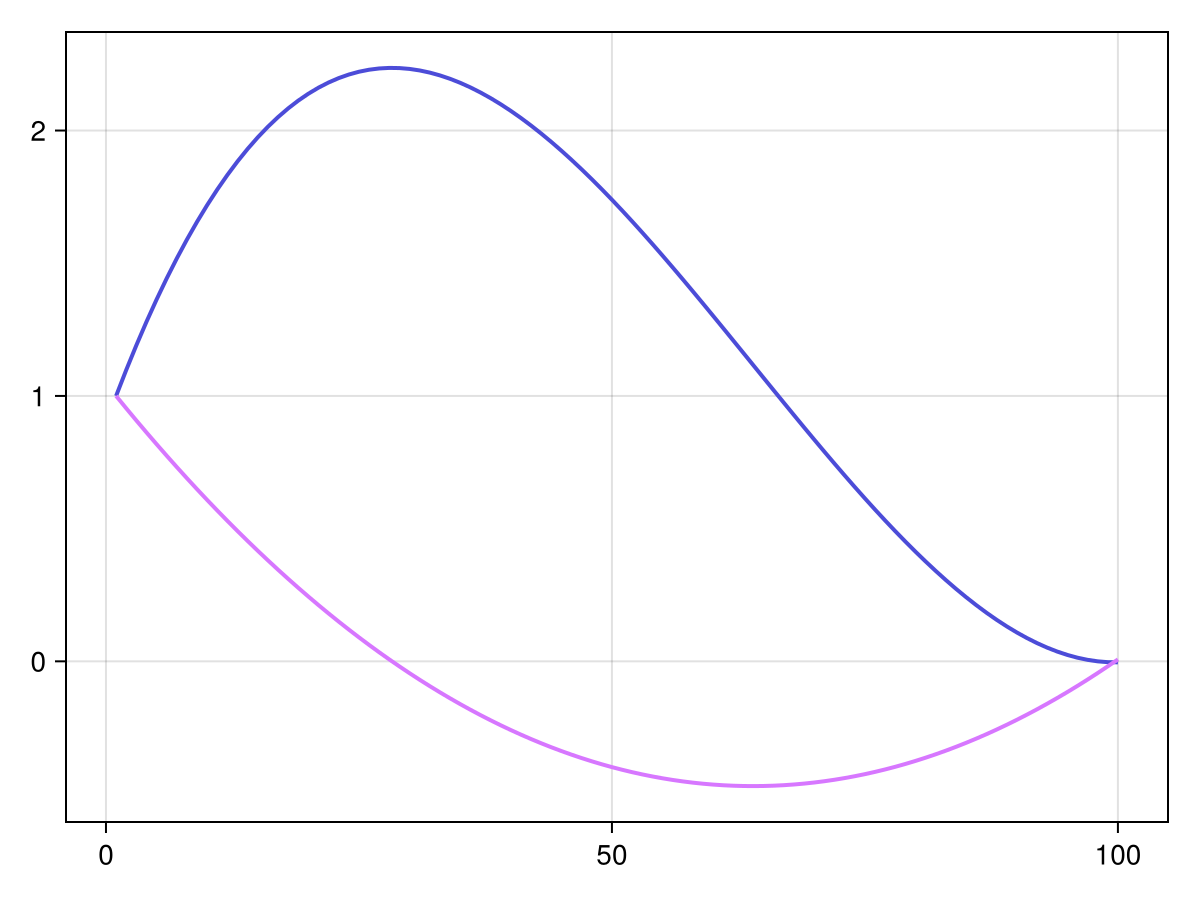

In [29]:
series(simulate_dlti(u, A, B, x1))

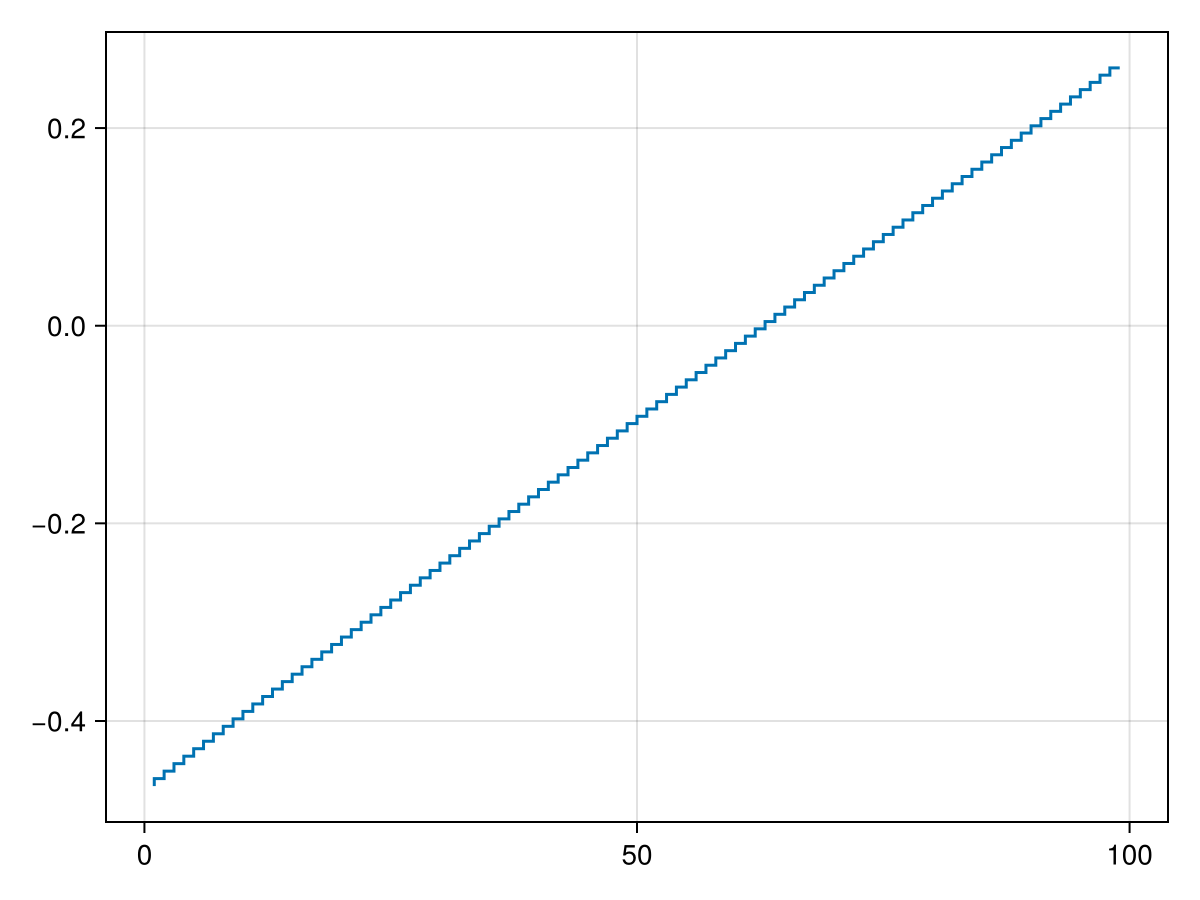

In [30]:
stairs(u[1, :])

**Exercise: Neural ODEs**

- Check out this [SciML note](https://docs.sciml.ai/DiffEqFlux/stable/examples/neural_ode/). Can we connect what we learned about Pontryagin to this work?

## Direct optimal control

**Tagline**

"discretize, then optimize"

**Ideas**

- Package the optimization variables into a trajectory
- Set up a quadratic program defined over the trajectory
- Observe the presence of sparsity

\begin{align}
\min_{x_{1:N}, u_{1:{N{-}1}}} &\quad J(x_{1:N}, u_{1:{N{-}1}}) = \sum_{n=1}^{N-1} \tfrac{1}{2} x_n^T Q_n x_n + \tfrac{1}{2} u_n^T R_n u_n + \tfrac{1}{2} x_N^T Q_N x_N \\
\text{s.t.} &\quad x_{n+1} = A_n x_n + B_n u_n \\
&\quad Q_n \succeq 0,\, R_n \succ 0
\end{align}




In [41]:
m = 0.1 # Mass
A_c, B_c = double_integrator(m)
h = 0.1  # Time step
A, B = sparse.(continuous_to_discrete(A_c, B_c, h))
x1 = [1.0; 1.0]  # Initial state

N = 100
x_dim = size(A, 2)
u_dim = size(B, 2)

Q = sparse(1e-4I(x_dim))
R = sparse(1e-2I(u_dim))
QN = sparse(1e2I(x_dim))

2×2 SparseMatrixCSC{Float64, Int64} with 2 stored entries:
 100.0     ⋅ 
    ⋅   100.0

Define 
\begin{align}
Z &= \begin{bmatrix} 
    x_1 & x_2 & \cdots & x_N \\
    u_1 & u_2 & \cdots & u_N 
\end{bmatrix} \\
\Rightarrow \vec{Z} &= \begin{bmatrix} x_1 \\ u_1 \\ x_2 \\ u_2 \\ \vdots \\ x_N \\ u_N \end{bmatrix}
\end{align}
and drop the first state (known) and last control (not used),
\begin{equation}
 z = \vec{Z}[\text{length}(x_1){:}\text{end}{-}\text{length}(u_N)]
\end{equation}

In [42]:
z_dim = (N-2) * (x_dim + u_dim) + u_dim + x_dim

297

Write the cost function as $J = \tfrac{1}{2} z^T H z$, where
\begin{equation}
    H = \begin{bmatrix}
        R_1 & 0 & 0 & & 0 \\
        0 & Q_2 & 0 & \cdots & 0 \\
        0 & 0 & R_2 & & 0 \\
        & \vdots & & \ddots & \vdots \\
        0 & 0 & 0 & \cdots & Q_N \\
    \end{bmatrix}.
\end{equation}

In [43]:
# Recall our shorthand for kron
H = blockdiag(sparse(R), I(N-2) ⊗ blockdiag(sparse(Q), sparse(R)), sparse(QN))

297×297 SparseMatrixCSC{Float64, Int64} with 297 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⎦

Write the dynamics constraint, $Cz = d$, where
\begin{equation}
C = \begin{bmatrix}
    B_1 & -I & 0 & 0 & & 0 \\
    0 & A_2 & B_2 & -I & \cdots & 0 \\
    \vdots & \vdots & \ddots & \ddots & \ddots & 0 \\
    0 & 0 & \cdots & A_{N-1} & B_{N-1} & -I
\end{bmatrix}, \qquad
d = \begin{bmatrix}
    -A_1 x_1 \\
    0 \\
    0 \\
    \vdots \\
    0
\end{bmatrix}
\end{equation}


In [44]:
C = I(N-1) ⊗ [B -I(x_dim)]
for k = 1:N-2
    C[(k * x_dim) .+ (1:x_dim), (k * (x_dim + u_dim) - x_dim) .+ (1:x_dim)] = A
end
C

198×297 SparseMatrixCSC{Float64, Int64} with 690 stored entries:
⎡⠛⢦⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠈⠙⢦⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠈⠙⢦⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⢶⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⠶⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⠶⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⠶⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⠶⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠶⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⠳⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠲⣤⡀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⠳⣤⡀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠲⣤⡀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⎦

In [45]:
# Check the structure of C
k = 6
(
    C[(k * x_dim) .+ (1:x_dim), (k * (x_dim + u_dim) - x_dim) .+ (1:(2x_dim + u_dim))] 
    == [A B -I(x_dim)]
)

true

In [46]:
d = [-A * x1; zeros((N-2) * x_dim)];

Putting it all together, 
\begin{align}
    \min_z &\quad \tfrac{1}{2} z^T H z \\
    \text{s.t.}&\quad C z = d
\end{align}

- Lagrangian:
\begin{equation}
    L(z, \lambda) = \tfrac{1}{2} z^T H z + \lambda^T (C z - d)
\end{equation}

- KKT conditions:
\begin{align}
    & \nabla_z L = H z + C^T \lambda \overset{!}{=} 0 \\
    & \nabla_\lambda L = Cz - d \overset{!}{=} 0 \\
\end{align}

- Matrix form:
\begin{equation}
    \Rightarrow \begin{bmatrix} H & C^T \\ C & 0 \end{bmatrix} 
    \begin{bmatrix} z \\ \lambda \end{bmatrix} 
    = \begin{bmatrix} 0 \\ d \end{bmatrix}
\end{equation}

- Quick check: How many iterations will this take to solve?

In [47]:
P = [H C'; C zeros(size(C, 1), size(C, 1))]

495×495 SparseMatrixCSC{Float64, Int64} with 1677 stored entries:
⎡⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢷⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎤
⎢⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢷⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢷⡀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣄⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⢷⡀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⣄⠀⎥
⎢⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢦⎥
⎢⠙⠳⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠙⠳⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠙⠳⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠳⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠳⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠳⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎢⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠳⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎥
⎣⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠲⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⎦

In [48]:
res_qp = P \ [zeros(z_dim); d]

# Extract the minimizer
z_minimizer = res_qp[1:z_dim]
u_minimizer = z_minimizer[1:x_dim + u_dim:end];

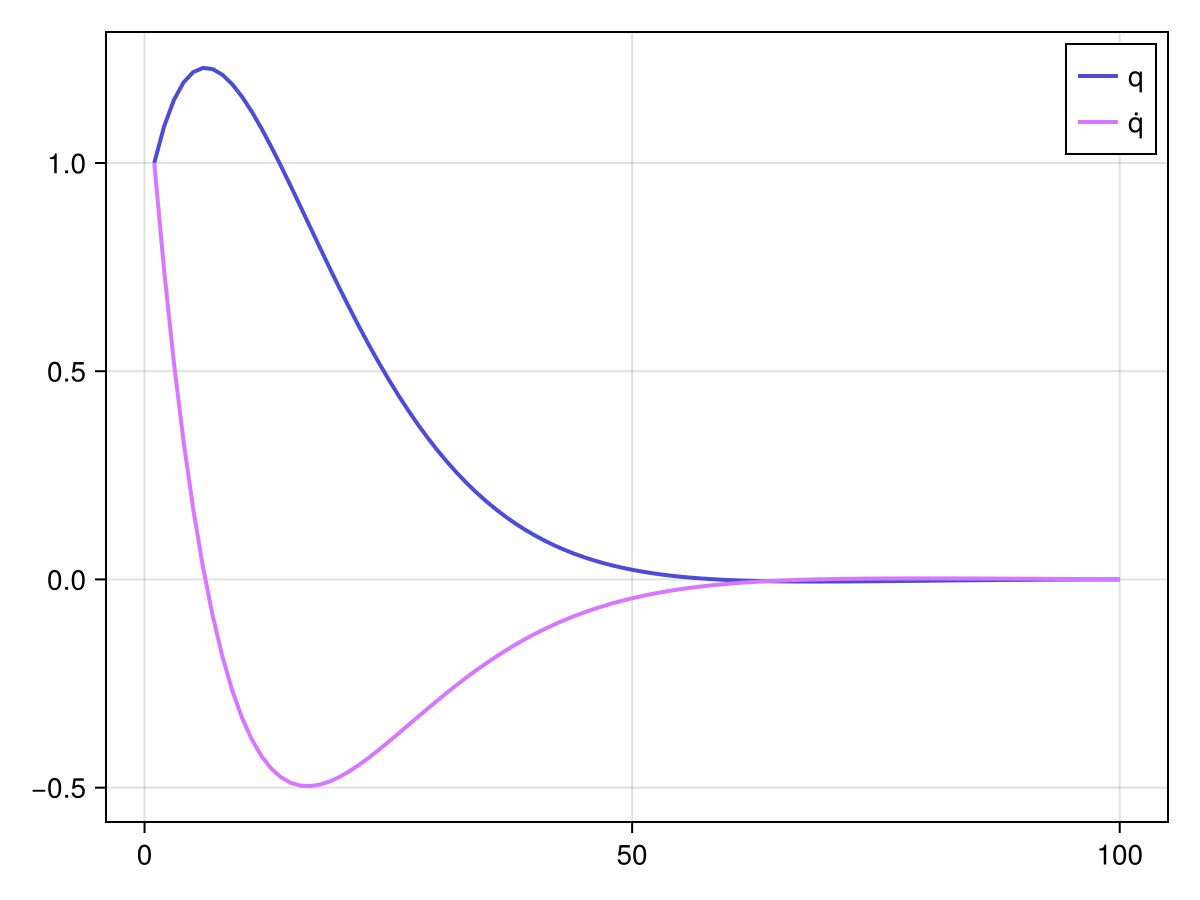

In [49]:
fig, ax = series(simulate_dlti(u_minimizer, A, B, x1), labels=["q", "q̇"])
axislegend(ax)
fig

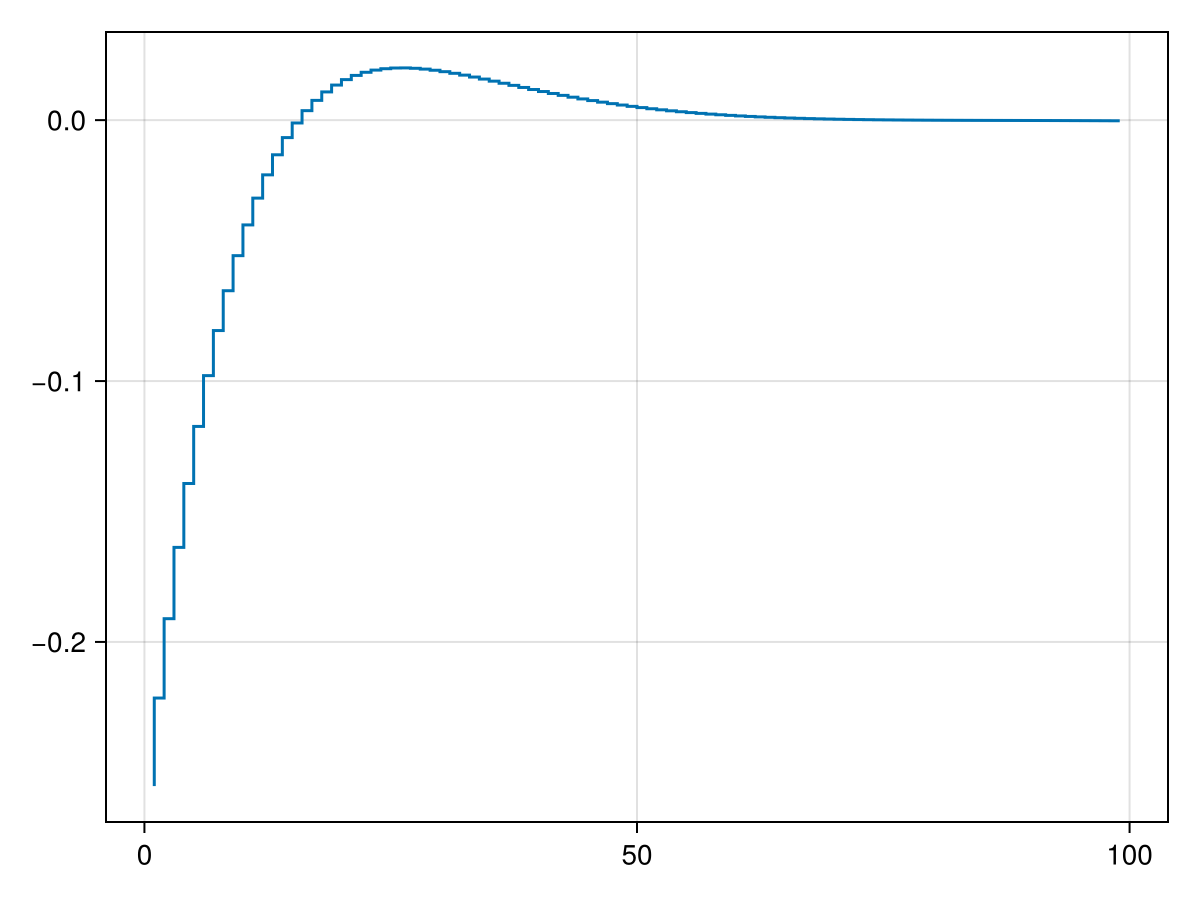

In [40]:
stairs(u_minimizer)

- Quick check: What about the temporal structure?